In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

In [36]:
dx = 0.01
N = 8192*4
data = np.fromfile("probe_fluid_1d_output.bin", dtype=np.float32).reshape(-1, N)

# remove per-snapshot mean
data = data - data.mean(axis=1, keepdims=True)


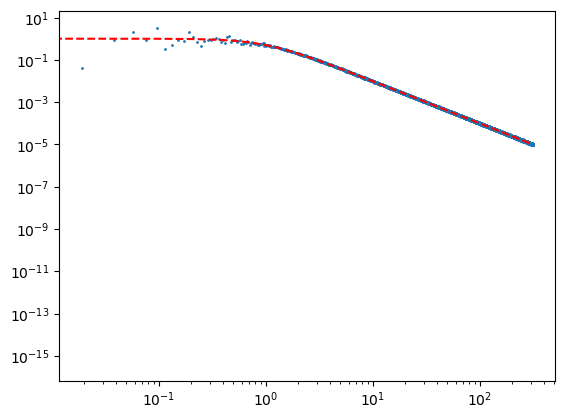

In [37]:
# rFFT (one-sided) and power
F = np.fft.rfft(data, axis=1)                  # shape: (nsnap, N//2+1)
S = (np.abs(F)**2) / N                          # unnormalized forward FFT

Sq = S.mean(axis=0)                              # average over snapshots
qpos = np.fft.rfftfreq(N, d=dx) * 2*np.pi
plt.scatter(qpos, Sq, s=1)
plt.plot(qpos[:], 1 / (1 + qpos[:]**2), 'r--')
plt.xscale('log'); plt.yscale('log'); plt.show()

In [95]:
def pbc_delta(a, b, L):
    """
    Minimal signed displacement from b -> a on a 1D periodic domain [0,L).
    Returns value in (-L/2, L/2].
    """
    return ( (a - b + 0.5*L) % L ) - 0.5*L

In [96]:
N = 8192*4
dx = 0.01
L  = N * dx
x = np.arange(N) * dx
q  = np.fft.fftfreq(N, d=dx) * 2*np.pi
q2 = q**2
dt = 0.001
temp_tilde = 1.0
mu_tilde = 1.0
lambda_tilde = 0.0
velocity_ratios = 0.0
timescales_factor = 100.0 # \tau_\phi / \tau_z
z_radius = 0.1
phi_q = fft.fft(np.ones(N)/L)
z = 0.0
integration_factor_q = np.exp(-(q2 * dt)*(1+q2))
noise_integration_factor_q = np.sqrt((temp_tilde)*(1 - np.exp(-2*(q2 * dt)*(1+q2)))/(1+q2))
gaussian_kernel_q = np.exp(-0.5 * (q * z_radius)**2)
gaussian_kernel_q /= np.sum(fft.ifft(gaussian_kernel_q).real) * dx  # normalize in real space
interaction_term_phi_q = lambda_tilde * gaussian_kernel_q * (1 - np.exp(-(q2 * dt)*(1+q2)))/(1+q2)
interaction_term_z_q = lambda_tilde * mu_tilde * (1.0j*q*gaussian_kernel_q)
num_steps = 10000
S_q_avg = np.zeros(N)
n_samples = 0
z_hist = np.zeros(num_steps)
for step in range(num_steps):
    z_hist[step] = z
    t = step * dt
    well_position = velocity_ratios*t % L
    well_force = mu_tilde*timescales_factor * pbc_delta(well_position, z, L)
    noise_q = fft.fft(np.random.normal(0, 1, N))
    phi_q = phi_q * integration_factor_q + interaction_term_phi_q*np.exp(-1.0j*q*z) + noise_q * noise_integration_factor_q
    z += dt*well_force + dt*(interaction_term_z_q*np.exp(1.0j*q*z)*phi_q).sum().real/N + np.sqrt(2*dt*mu_tilde*temp_tilde)*np.random.normal(0, 1)
    z = z % L
    z = np.floor(z/dx)*dx
    if step > num_steps//2 and step % 100 == 0:  # After equilibration
        phi = fft.ifft(phi_q).real
        phi_fluct = phi - phi.mean()
        S_q = (np.abs(fft.fft(phi_fluct))**2)/N
        S_q_avg += S_q
        n_samples += 1
S_q_avg /= n_samples

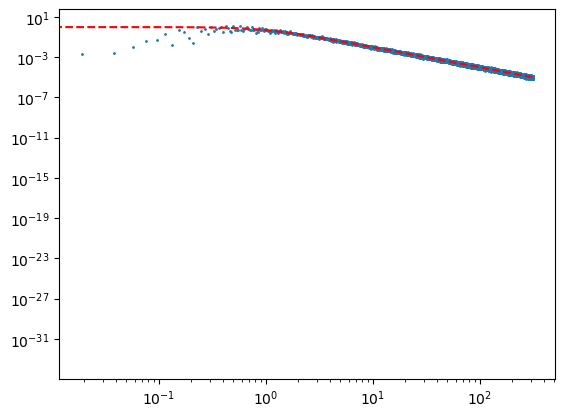

In [98]:
plt.scatter(q[:N//2], S_q_avg[:N//2], s=1)
plt.plot(q[:N//2],1.0/(1+q[:N//2]**2),'r--')
plt.yscale('log')
plt.xscale('log')
plt.show()

In [4]:
y = pbc_delta(velocity_ratios*np.arange(0, num_steps)*dt, z_hist, L)

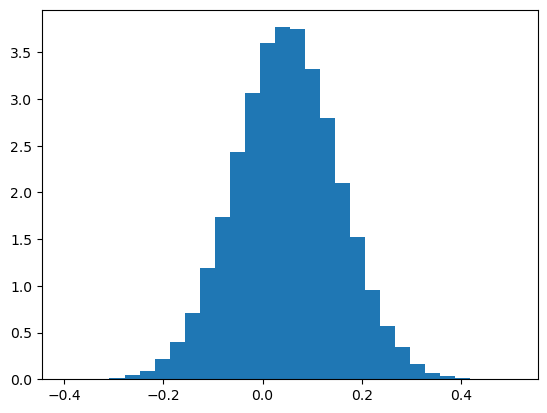

In [5]:
plt.hist(y[5000:], bins=30, density=True)
plt.show()

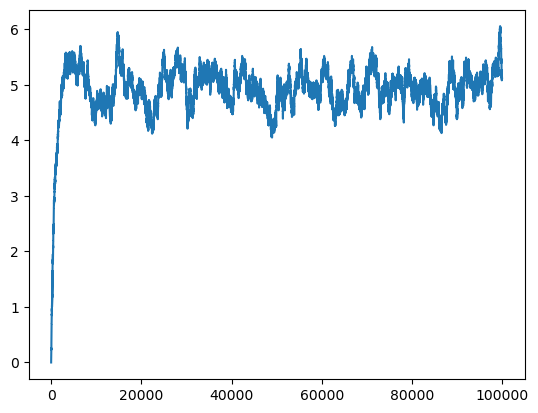

In [92]:
plt.plot(pbc_delta(velocity_ratios*np.arange(0, num_steps)*dt, z_hist, L))

In [ ]:
Nx = 2048
Ny = 64
phi = np.fromfile("phi_final.bin", dtype=np.float32).reshape((-1, Ny, Nx))
phi.shape
probe = np.loadtxt('probe.txt')
record_steps = 100
plt.plot(probe[:,2])

In [ ]:

#for idx in range(phi.shape[0]):
#    plt.contourf(phi[idx], cmap='seismic')
#    plt.colorbar()
#    plt.scatter(probe[idx*record_steps,1], probe[idx*record_steps,2], color='black')
#    plt.title(f'Time {idx*record_steps}')
#    plt.pause(0.1)
#    plt.clf()
#plt.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection

# --- your helper (as given) ---------------------------------------------------
def split_segments_for_pbc(pos, Lx, Ly):
    """
    pos: (T,2) in [0,Lx)×[0,Ly)
    returns a list of segments (each is (N_i,2)) that do not cross seams.
    """
    segs = []
    current = [pos[0]]
    for i in range(1, len(pos)):
        p0 = pos[i-1]; p1 = pos[i]
        dx = p1[0] - p0[0]
        dy = p1[1] - p0[1]
        cross = (abs(dx) > 0.5*Lx) or (abs(dy) > 0.5*Ly)
        if cross:
            if len(current) > 1:
                segs.append(np.array(current))
            current = [p1]
        else:
            current.append(p1)
    if len(current) > 1:
        segs.append(np.array(current))
    return segs

# --- params you must have -----------------------------------------------------
# phi: (T, Ny, Nx)
# probe: (T, 2) positions in [0,Lx)×[0,Ly)
# record_steps: int
# Lx, Ly: box lengths
vmin, vmax = np.quantile(phi, 0.2), np.quantile(phi, 0.8)
levels = 25

frames =  phi.shape[0]

fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)
cf = ax.contourf(phi[0], levels=levels, vmin=vmin, vmax=vmax, cmap='seismic', alpha=0.5)
cb = fig.colorbar(cf, ax=ax, label='field')

# Use a LineCollection for many segments
traj_coll = LineCollection([], colors='black', linewidths=1.5)
ax.add_collection(traj_coll)

# Optional: current particle marker
pt, = ax.plot(probe[0:1,0], probe[0:1,1], 'ko', ms=3)

#ax.set(xlim=(0, Nx), ylim=(0, Ny), aspect='equal')
title = ax.set_title('t = 0')

def update(frame):
    # map animation frame -> simulation index
    t =  frame*record_steps

    # ---- refresh contourf without deprecated attributes ----
    for c in list(ax.collections):
        if c is traj_coll:  # keep our trajectory collection
            continue
        c.remove()
    new_cf = ax.contourf(phi[frame], levels=levels, vmin=vmin, vmax=vmax, cmap='seismic', alpha=0.5)
    cb.update_normal(new_cf)  # keep same colorbar

    # ---- split trajectory at PBC seams and update LineCollection ----
    segs = split_segments_for_pbc(probe[:t+1, :2], Nx, Ny)
    traj_coll.set_segments(segs)

    # ---- update current particle marker (wrapped) ----
    xw = probe[t,0] % Nx
    yw = probe[t,1] % Ny
    pt.set_data([xw], [yw])

    title.set_text(f't = {t}')
    # with blit=False, return value is ignored; keep it light
    return [traj_coll, pt, title]

ani = FuncAnimation(fig, update, frames=phi.shape[0], interval=30, blit=False)
ani.save('probe_field.mp4', dpi=50)
plt.close(fig)